In [3]:
import glob
import numpy as np
import pandas as pd
import av
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import datetime
import calendar
from tqdm import tqdm

# dataset_dir = "/home/arthur/felles/Research/Users/Alexander/Still Standing/1-raw"
dataset_dir = "/fp/homes01/u01/ec-jinyueg/felles1/Research/Users/Alexander/Still Standing"

RuntimeError: CPU dispatcher tracer already initlized

In [6]:
metadata = pd.read_csv("../metadata.csv")
print(metadata.columns)
metadata = metadata[['StillStandingNo', 'Date', 'processed_watch_path', 'processed_phone_path']].dropna()
metadata

Index(['StillStandingNo', 'Date', 'Audio Clap Start', 'Audio Clap End',
       'Mobile Timecode', 'Mobile Clap Start', 'Mobile Clap End',
       'Video Clap Start', 'Video Clap End', 'Video Crop Height',
       'Video Crop Width', 'Video Crop X Position', 'Video Crop Y Position',
       'Video Crop Ratio', 'Watch Timecode', 'source_audio_path',
       'source_video_LRV_1_path', 'source_video_LRV_2_path',
       'source_video_LRV_3_path', 'source_video_LRV_4_path',
       'source_video_360_1_path', 'source_video_360_2_path',
       'source_video_360_3_path', 'source_video_360_4_path',
       'source_watch_csv_path', 'source_phone_path',
       'processed_video_spherical_path', 'processed_audio_path',
       'processed_watch_path', 'processed_phone_path'],
      dtype='object')


,StillStandingNo,Date,processed_watch_path,processed_phone_path
0,1,2023-01-01,1-raw/01/2023-01-01/2-processed/stillstanding_...,1-raw/01/2023-01-01/2-processed/stillstanding_...
1,2,2023-01-02,1-raw/01/2023-01-02/2-processed/stillstanding_...,1-raw/01/2023-01-02/2-processed/stillstanding_...
2,3,2023-01-03,1-raw/01/2023-01-03/2-processed/stillstanding_...,1-raw/01/2023-01-03/2-processed/stillstanding_...
3,4,2023-01-04,1-raw/01/2023-01-04/2-processed/stillstanding_...,1-raw/01/2023-01-04/2-processed/stillstanding_...
4,5,2023-01-05,1-raw/01/2023-01-05/2-processed/stillstanding_...,1-raw/01/2023-01-05/2-processed/stillstanding_...
...,...,...,...,...
360,361,2023-12-27,1-raw/12/2023-12-27/2-processed/stillstanding_...,1-raw/12/2023-12-27/2-processed/stillstanding_...
361,362,2023-12-28,1-raw/12/2023-12-28/2-processed/stillstanding_...,1-raw/12/2023-12-28/2-processed/stillstanding_...
362,363,2023-12-29,1-raw/12/2023-12-29/2-processed/stillstanding_...,1-raw/12/2023-12-29/2-processed/stillstanding_...
363,364,2023-12-30,1-raw/12/2023-12-30/2-processed/stillstanding_...,1-raw/12/2023-12-30/2-processed/stillstanding_...


In [7]:
phone_path = os.path.join(dataset_dir, metadata.processed_phone_path[0])
loudness = pd.read_csv(phone_path)[['time', 'Gain']]
loudness

,time,Gain
0,0.000000,40.1483
1,0.056508,40.1483
2,0.115161,39.9082
3,0.175719,39.9082
4,0.233795,39.9082
...,...,...
8330,499.721141,41.0135
8331,499.772160,41.0135
8332,499.838246,41.0135
8333,499.896197,41.0135


In [8]:
watch_path = os.path.join(dataset_dir, metadata.processed_watch_path[0])
hr = pd.read_csv(watch_path)[['Time', 'HR (bpm)']].ffill()
hr.head(20)

,Time,HR (bpm)
0,0.0,71.0
1,1.0,71.0
2,2.0,71.0
3,3.0,71.0
4,4.0,71.0
5,5.0,71.0
6,6.0,71.0
7,7.0,71.0
8,8.0,71.0
9,9.0,71.0


## Seasonal, monthly and daily patterns

In [10]:
loudness_avg_list, loudness_std_list, hr_avg_list, hr_std_list = [], [], [], []

for i, row in tqdm(metadata.iterrows()):
    phone_path = os.path.join(dataset_dir, row.processed_phone_path)
    loudness = pd.read_csv(phone_path)[['time', 'Gain']]
    loudness_avg = np.mean(loudness['Gain'])
    loudness_std = np.std(loudness['Gain'])
    loudness_avg_list.append(loudness_avg)
    loudness_std_list.append(loudness_std)

    watch_path = os.path.join(dataset_dir, row.processed_watch_path)
    hr = pd.read_csv(watch_path)[['Time', 'HR (bpm)']].ffill()
    n_repeat = int(len(loudness)/len(hr))+1
    hr_interp = hr['HR (bpm)'].to_numpy().repeat(n_repeat)[:len(loudness)]
    hr_avg = np.mean(hr_interp)
    hr_std = np.std(hr_interp)

    hr_avg_list.append(hr_avg)
    hr_std_list.append(hr_std)

metadata['loudness_avg'] = loudness_avg_list
metadata['loudness_std'] = loudness_std_list
metadata['hr_avg'] = hr_avg_list
metadata['hr_std'] = hr_std_list

355it [00:13, 26.20it/s]


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=metadata, x='loudness_avg', y='hr_avg')
plt.subplot(1, 2, 2)
sns.scatterplot(data=metadata, x='loudness_std', y='hr_std')
plt.show()

## Correlation of Loudness & HR

In [19]:
n_repeat = int(len(loudness)/len(hr))+1
hr_interp = hr['HR (bpm)'].to_numpy().repeat(n_repeat)[:len(loudness)]

In [34]:
results = scipy.stats.pearsonr(loudness['Gain'], hr_interp)
print(results.correlation, results.pvalue)
print(results.confidence_interval(0.95))

-0.029863205359749477 0.0063991148450312325
ConfidenceInterval(low=np.float64(-0.0512990644924), high=np.float64(-0.008399842435960573))


In [63]:

loudness_avg_list, loudness_std_list, hr_avg_list, hr_std_list, correlation_list, pvalue_list, confidence_interval_low_list, confidence_interval_high_list = [], [], [], [], [], [], [], []

for i, row in tqdm(metadata.iterrows()):
    phone_path = os.path.join(dataset_dir, row.processed_phone_path)
    loudness = pd.read_csv(phone_path)[['time', 'Gain']]
    loudness_avg = np.mean(loudness['Gain'])
    loudness_std = np.std(loudness['Gain'])

    watch_path = os.path.join(dataset_dir, row.processed_watch_path)
    hr = pd.read_csv(watch_path)[['Time', 'HR (bpm)']].ffill()
    n_repeat = int(len(loudness)/len(hr))+1
    hr_interp = hr['HR (bpm)'].to_numpy().repeat(n_repeat)[:len(loudness)]
    hr_avg = np.mean(hr_interp)
    hr_std = np.std(hr_interp)

    results = scipy.stats.pearsonr(loudness['Gain'], hr_interp)

    correlation_list.append(results.correlation)
    pvalue_list.append(results.pvalue)
    confidence_interval = results.confidence_interval(0.95)
    confidence_interval_low_list.append(confidence_interval[0])
    confidence_interval_high_list.append(confidence_interval[1])
    hr_avg_list.append(hr_avg)
    hr_std_list.append(hr_std)

metadata['loudness_avg'] = loudness_avg_list
metadata['loudness_std'] = loudness_std_list
metadata['hr_avg'] = hr_avg_list
metadata['hr_std'] = hr_std_list
metadata['correlation'] = correlation_list
metadata['pvalue'] = pvalue_list
metadata['confidence_interval_low'] = confidence_interval_low_list
metadata['confidence_interval_high'] = confidence_interval_high_list

355it [00:14, 24.47it/s]


ValueError: Length of values (0) does not match length of index (355)

In [37]:
metadata

,StillStandingNo,Date,processed_watch_path,processed_phone_path,correlation,pvalue,confidence_interval_low,confidence_interval_high
0,1,2023-01-01,1-raw/01/2023-01-01/2-processed/stillstanding_...,1-raw/01/2023-01-01/2-processed/stillstanding_...,-0.029863,6.399115e-03,-0.051299,-0.008400
1,2,2023-01-02,1-raw/01/2023-01-02/2-processed/stillstanding_...,1-raw/01/2023-01-02/2-processed/stillstanding_...,-0.293075,9.284639e-165,-0.312577,-0.273326
2,3,2023-01-03,1-raw/01/2023-01-03/2-processed/stillstanding_...,1-raw/01/2023-01-03/2-processed/stillstanding_...,0.118080,2.876306e-27,0.096857,0.139196
3,4,2023-01-04,1-raw/01/2023-01-04/2-processed/stillstanding_...,1-raw/01/2023-01-04/2-processed/stillstanding_...,-0.124694,3.089066e-30,-0.145774,-0.103501
4,5,2023-01-05,1-raw/01/2023-01-05/2-processed/stillstanding_...,1-raw/01/2023-01-05/2-processed/stillstanding_...,0.050945,3.264864e-06,0.029509,0.072335
...,...,...,...,...,...,...,...,...
360,361,2023-12-27,1-raw/12/2023-12-27/2-processed/stillstanding_...,1-raw/12/2023-12-27/2-processed/stillstanding_...,-0.042613,2.257991e-04,-0.065202,-0.019980
361,362,2023-12-28,1-raw/12/2023-12-28/2-processed/stillstanding_...,1-raw/12/2023-12-28/2-processed/stillstanding_...,0.240005,1.472051e-98,0.218540,0.261238
362,363,2023-12-29,1-raw/12/2023-12-29/2-processed/stillstanding_...,1-raw/12/2023-12-29/2-processed/stillstanding_...,-0.108143,6.471145e-21,-0.130478,-0.085698
363,364,2023-12-30,1-raw/12/2023-12-30/2-processed/stillstanding_...,1-raw/12/2023-12-30/2-processed/stillstanding_...,0.239903,1.842988e-98,0.218435,0.261139


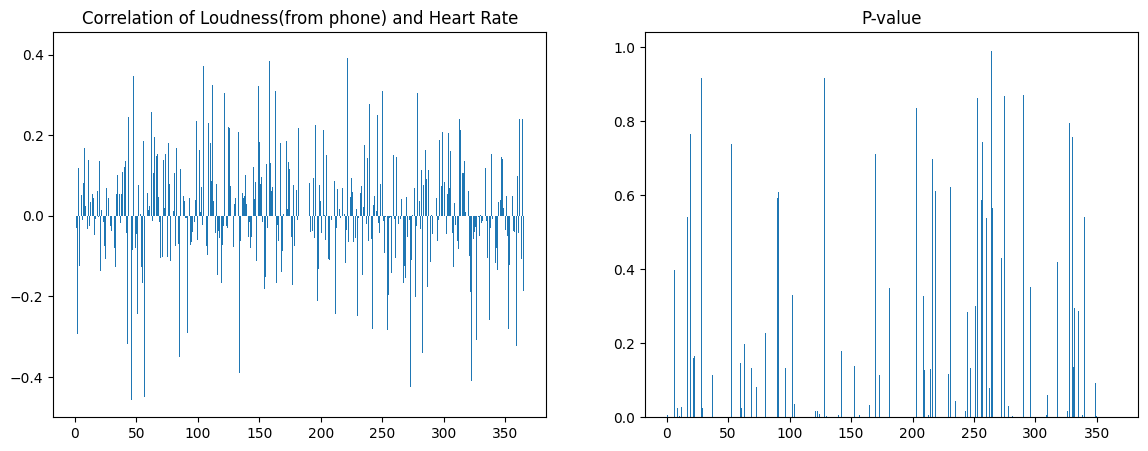

In [52]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.bar(metadata['StillStandingNo'], metadata['correlation'])
plt.title('Correlation of Loudness(from phone) and Heart Rate')
plt.subplot(122)
plt.bar(metadata['StillStandingNo'], metadata['pvalue'])
plt.title('P-value')

plt.show()

## Brightness and HR

In [45]:
phone_path = os.path.join(dataset_dir, metadata.processed_phone_path[0])
brightness = pd.read_csv(phone_path)[['time', 'I']]
brightness

,time,I
0,0.000000,235.0
1,0.056508,235.0
2,0.115161,235.0
3,0.175719,235.0
4,0.233795,235.0
...,...,...
8330,499.721141,291.0
8331,499.772160,290.0
8332,499.838246,290.0
8333,499.896197,290.0


In [3]:
from scipy.stats import ConstantInputWarning
correlation_list, pvalue_list, confidence_interval_low_list, confidence_interval_high_list = [], [], [], []

for i, row in tqdm(metadata.iterrows()):
    phone_path = os.path.join(dataset_dir, row.processed_phone_path)
    brightness = pd.read_csv(phone_path)[['time', 'I']]

    watch_path = os.path.join(dataset_dir, row.processed_watch_path)
    hr = pd.read_csv(watch_path)[['Time', 'HR (bpm)']].ffill()
    n_repeat = int(len(brightness)/len(hr))+1
    hr_interp = hr['HR (bpm)'].to_numpy().repeat(n_repeat)[:len(brightness)]

    try:
        results = scipy.stats.pearsonr(brightness['I'], hr_interp)
    except ConstantInputWarning:
        print(f"ConstantInputWarning: {row.StillStandingNo}")

    correlation_list.append(results.correlation)
    pvalue_list.append(results.pvalue)
    confidence_interval = results.confidence_interval(0.95)
    confidence_interval_low_list.append(confidence_interval[0])
    confidence_interval_high_list.append(confidence_interval[1])

metadata['correlation'] = correlation_list
metadata['pvalue'] = pvalue_list
metadata['confidence_interval_low'] = confidence_interval_low_list
metadata['confidence_interval_high'] = confidence_interval_high_list

RuntimeError: CPU dispatcher tracer already initlized

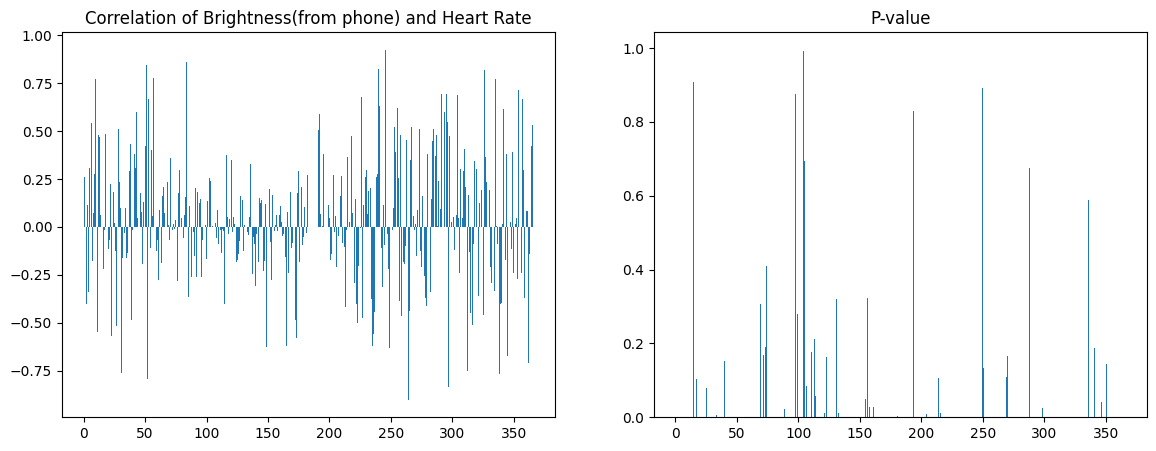

In [62]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.bar(metadata['StillStandingNo'], metadata['correlation'])
plt.title('Correlation of Brightness(from phone) and Heart Rate')
plt.subplot(122)
plt.bar(metadata['StillStandingNo'], metadata['pvalue'])
plt.title('P-value')

plt.show()